<a href="https://colab.research.google.com/github/sayakpaul/SimSiam-TF/blob/main/SimSiam_Pre_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A minimal implementation of **SimSiam** as proposed in [Exploring Simple Siamese Representation Learning](https://arxiv.org/pdf/2011.10566.pdf) by Xinlei Chen and Kaiming He. The objective of this notebook is to demonstrate the workflow of SimSiam and NOT to implement it note to note and at the same time I will try not to miss out on the major bits discussed in the paper. For that matter, I'll be using the Flowers dataset. 

Following depicts the workflow of SimSiam - 

<center>
<img src="https://i.ibb.co/37pNQTP/image.png" width=550></img>
</center>

In [1]:
!pip install -U -q tensorflow-addons

In [2]:
import tensorflow as tf
print(tf.__version__)

2.3.1


In [3]:
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import numpy as np
import random
import time
import os

from tqdm import tqdm

tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()

In [4]:
!nvidia-smi

Sun Nov 29 05:01:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    39W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"]
)

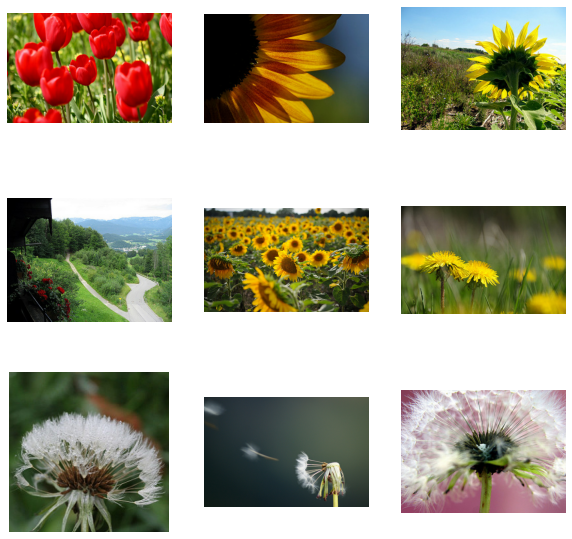

In [6]:
# Visualization
plt.figure(figsize=(10, 10))
for i, image  in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image['image'])
    plt.axis("off")

Note the augmentation pipeline is a bit different from the augmentations followed in the paper. 

In [7]:
# Reference: https://github.com/google-research/simclr/blob/master/data_util.py

@tf.function
def translate(image):
    (h, w) = tf.shape(image)[0], tf.shape(image)[1]
    image = tf.image.random_flip_left_right(image)

    f = tf.random.uniform([], minval=0, maxval=0.125, dtype=tf.float32)
    (dh, dw) = tf.cast(tf.cast(h, tf.float32)*f, tf.float32), \
        tf.cast(tf.cast(w, tf.float32)*f, tf.float32)
    
    image = tfa.image.translate(image, translations=[dh, dw])
    return image

@tf.function
def gaussian_blur(image, kernel_size=23, padding='SAME'):
    sigma = tf.random.uniform((1,))* 1.9 + 0.1

    radius = tf.cast(kernel_size / 2, tf.int32)
    kernel_size = radius * 2 + 1
    x = tf.cast(tf.range(-radius, radius + 1), tf.float32)
    blur_filter = tf.exp(
        -tf.pow(x, 2.0) / (2.0 * tf.pow(tf.cast(sigma, tf.float32), 2.0)))
    blur_filter /= tf.reduce_sum(blur_filter)
    # One vertical and one horizontal filter.
    blur_v = tf.reshape(blur_filter, [kernel_size, 1, 1, 1])
    blur_h = tf.reshape(blur_filter, [1, kernel_size, 1, 1])
    num_channels = tf.shape(image)[-1]
    blur_h = tf.tile(blur_h, [1, 1, num_channels, 1])
    blur_v = tf.tile(blur_v, [1, 1, num_channels, 1])
    expand_batch_dim = image.shape.ndims == 3
    if expand_batch_dim:
        image = tf.expand_dims(image, axis=0)
    blurred = tf.nn.depthwise_conv2d(
        image, blur_h, strides=[1, 1, 1, 1], padding=padding)
    blurred = tf.nn.depthwise_conv2d(
        blurred, blur_v, strides=[1, 1, 1, 1], padding=padding)
    if expand_batch_dim:
        blurred = tf.squeeze(blurred, axis=0)
    return blurred

@tf.function
def color_jitter(x, s=0.5):
    x = tf.image.random_brightness(x, max_delta=0.8*s)
    x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
    x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
    x = tf.image.random_hue(x, max_delta=0.2*s)
    x = tf.clip_by_value(x, 0, 1)
    return x

@tf.function
def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x

@tf.function
def random_apply(func, x, p):
    return tf.cond(
        tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                tf.cast(p, tf.float32)),
        lambda: func(x),
        lambda: x)

@tf.function
def custom_augment(image):
    image = image['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (224, 224))

    # Random flips
    image = random_apply(tf.image.flip_left_right, image, p=0.5)
    # Random translations
    image = random_apply(translate, image, p=0.5)
    # Randomly apply gausian blur
    image = random_apply(gaussian_blur, image, p=0.5)
    # Randomly apply transformation (color distortions) 
    image = random_apply(color_jitter, image, p=0.8)
    # Randomly apply grayscale
    image = random_apply(color_drop, image, p=0.2)
    
    return image

In [8]:
BATCH_SIZE = 64
AUTO = tf.data.experimental.AUTOTUNE

dataset_one = (
    train_ds
    .shuffle(1024)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

dataset_two = (
    train_ds
    .shuffle(1024)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

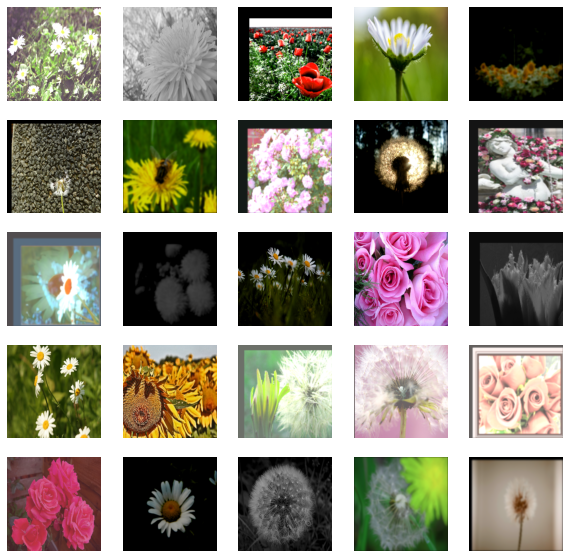

In [9]:
sample_images = next(iter(dataset_one))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(sample_images[n])
    plt.axis('off')
plt.show()

The network architectures are based on the **Method (Baseline settings)** section of the paper. 

## Encoder ($f$)

This includes ResNet50 as a backbone and another MLP for projection. Note that I have reduced the architectures here leaving ResNet50 backbone intact. 

In [10]:
def get_encoder():
    base_model = tf.keras.applications.ResNet50(include_top=False,
        weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True

    inputs = tf.keras.layers.Input((224, 224, 3))
    x = base_model(inputs, training=True)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(2048, activation='relu', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    z = tf.keras.layers.Dense(2048)(x)

    f = tf.keras.Model(inputs, z)

    return f

## Predictor ($h$)

This includes an MLP. 

In [11]:
def get_predictor():
    inputs = tf.keras.layers.Input((2048, ))
    x = tf.keras.layers.Dense(512, activation='relu', use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    p = tf.keras.layers.Dense(2048)(x)

    h = tf.keras.Model(inputs, p)

    return h

In [12]:
get_encoder().summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4194304   
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
Total params: 31,986,560
Trainable params: 31,929,344
Non-trainable params: 57,216
_____________________________________

In [13]:
get_predictor().summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1048576   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              1050624   
Total params: 2,101,248
Trainable params: 2,100,224
Non-trainable params: 1,024
_________________________________________________________________


The authors have also provided PyTorch-like psuedocode in the paper (how cool!) - 

```python
# f: backbone + projection mlp
# h: prediction mlp
for x in loader: # load a minibatch x with n samples
    x1, x2 = aug(x), aug(x) # random augmentation
    z1, z2 = f(x1), f(x2) # projections, n-by-d
    p1, p2 = h(z1), h(z2) # predictions, n-by-d
    L = D(p1, z2)/2 + D(p2, z1)/2 # loss
    L.backward() # back-propagate
    update(f, h) # SGD update

def D(p, z): # negative cosine similarity
    z = z.detach() # stop gradient
    p = normalize(p, dim=1) # l2-normalize
    z = normalize(z, dim=1) # l2-normalize
    return -(p*z).sum(dim=1).mean()
```

In [14]:
def loss_func(p, z):
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    return - tf.reduce_mean(tf.reduce_sum((p*z), axis=1))

In [15]:
@tf.function
def train_step(ds_one, ds_two, f, h, optimizer):
    with tf.GradientTape() as tape:
        z1, z2 = f(ds_one), f(ds_two)
        p1, p2 = h(z1), h(z2)
        loss = loss_func(p1, z2)/2 + loss_func(p2, z1)/2
    
    learnable_params = f.trainable_variables + h.trainable_variables
    gradients = tape.gradient(loss, learnable_params)
    optimizer.apply_gradients(zip(gradients, learnable_params))

    return loss

In [16]:
def train_simsiam(f, h, dataset_one, dataset_two, optimizer, epochs=100):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in tqdm(range(epochs)):
        for ds_one, ds_two in zip(dataset_one, dataset_two):
            loss = train_step(ds_one, ds_two, f, h, optimizer)
            step_wise_loss.append(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))

        if epoch % 10 == 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, f, h

In [17]:
decay_steps = 500
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.01, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6)

f = get_encoder()
h = get_predictor()

epoch_wise_loss, f, h  = train_simsiam(f, h, dataset_one, dataset_two, optimizer, epochs=50)

  2%|▏         | 1/50 [00:53<43:54, 53.77s/it]

epoch: 1 loss: -0.454


 22%|██▏       | 11/50 [06:48<23:21, 35.95s/it]

epoch: 11 loss: -0.914


 42%|████▏     | 21/50 [12:43<17:08, 35.46s/it]

epoch: 21 loss: -0.945


 62%|██████▏   | 31/50 [18:37<11:10, 35.29s/it]

epoch: 31 loss: -0.956


 82%|████████▏ | 41/50 [24:35<05:21, 35.69s/it]

epoch: 41 loss: -0.961


100%|██████████| 50/50 [29:57<00:00, 35.96s/it]


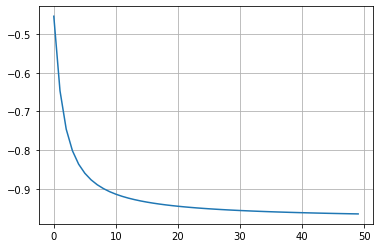

In [19]:
plt.plot(epoch_wise_loss)
plt.grid()
plt.show()

In [20]:
f.save_weights("projection.h5")
h.save_weights("prediction.h5")